In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys

higher_dir = '../'
sys.path.append(higher_dir)

from JetsFromFile import JetsFromFile
from JetImages import JetImage

kappa = 0.2
is_up      : np.ndarray = np.empty(0, dtype=np.int32)
jet_images : np.ndarray = np.empty((0, 2, JetImage.pixels_per_dim, JetImage.pixels_per_dim), dtype=np.float32)

energy_gev = 100
print("\nLoading jets from files. Currently on seed: ", end='')
for seed in range(1,2):
    if (seed-1) % 5 == 0:
        print("{}...".format(seed), end='')

    for origin in ['up', 'down']:

        datadir = "../data/up_down/"

        jets_to_load = JetsFromFile(energy_gev, origin, seed, datadir)
    
        new_images   = np.stack([JetImage.two_channel_image(jet, kappa) for jet in jets_to_load.from_txt()])
                        
        jet_images = np.concatenate((jet_images, new_images), axis=0)

        is_up      = np.concatenate((is_up, np.full(len(new_images), type == 'up')))


jet_images = JetImage.preprocess_many_images(jet_images)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Loading jets from files. Currently on seed: 1...

In [35]:
jet_images

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., -0., -0., -0.],
         [-0., -0., -0., ..., 

In [27]:
# Normalize the whole image by the sum of its pixels in each channel
first_channel = jet_images[:,0,:,:]
num_images = first_channel.shape[0]
first_channel = first_channel.reshape(num_images,1,33,33)

normalized = first_channel /  np.sum(first_channel, axis=(2,3), keepdims=True)

# Zero-center each channel's pixels by the corresponding average over all images
zero_centered = normalized - np.mean(normalized, axis=(0), keepdims=True)

# Standardize each channel by the channel-standard-deviation over all images
for_noise_reduction = 1e-6
standardized = zero_centered /  (np.std(normalized, axis=(0), keepdims=True) + for_noise_reduction)

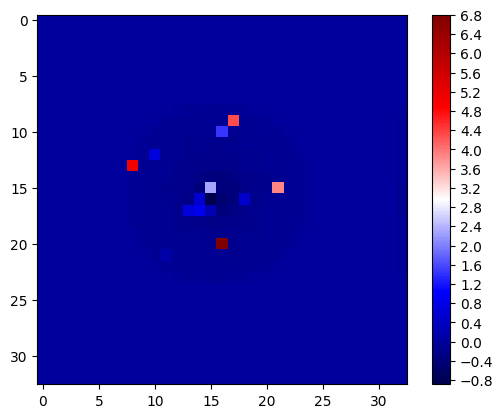

In [39]:
# m = normalized
# m = zero_centered
m = jet_images
# range = np.max(m) - np.min(m)
# m  -= np.min(m)
# m /= range

# to_plot = np.mean(m, axis=0)[0,:,:]
to_plot = m[2,0,:,:]

import matplotlib.pyplot as plt 
# import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plt.imshow(to_plot, cmap='seismic')
# plt.colorbar(100)

# Create a figure and axis
fig, ax = plt.subplots()

# Create a colorbar with more subdivisions
cax = ax.imshow(to_plot, cmap='seismic')
cbar = fig.colorbar(cax, ax=ax)

# Set the number of ticks on the colorbar
cbar.locator = ticker.MaxNLocator(nbins=20)  # Set the number of subdivisions
cbar.update_ticks()

# Show the plot
plt.show()

In [17]:
%load_ext autoreload
%autoreload 2

from Model import CNN
import torch
from torchvision import tv_tensors 

model = CNN(1)

total_num_images = len(is_up)
percent_train    = 0.8
last_training_idx = int(total_num_images * percent_train)

## Todo: Augment the data images by:
    ## 1. Flipping the image along the vertical axis
    ## 2. Flipping the image along the horizontal axis
    ## 3. Translating image by one pixel in each direction

# training_images = tv_tensors.Image(standardized[:last_training_idx]).float()
# training_labels = torch.tensor(is_up[:last_training_idx]).long()

# validation_images = tv_tensors.Image(standardized[last_training_idx:]).float()
# validation_labels = torch.tensor(is_up[last_training_idx:]).long()

# print(model(training))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'is_up' is not defined

In [57]:
batch_size = 512

training_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(training_images, training_labels),
    batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(validation_images, validation_labels),
    batch_size=batch_size, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [50]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        # inputs = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [58]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer    = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

num_epochs = 5

best_vloss = 1_000_000.

for epoch in range(num_epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.9644201397895813
EPOCH 2:
LOSS train 0.0 valid 0.9339417815208435
EPOCH 3:
LOSS train 0.0 valid 0.9815530776977539
EPOCH 4:
LOSS train 0.0 valid 0.9200370907783508
EPOCH 5:
LOSS train 0.0 valid 1.0277581214904785


In [6]:
def zero_center(*args, channels = [], copy = False):

    """ Subtracts the mean of arg[0,channels] from the other arguments.
    Assumes that the arguments are numpy arrays. The expected use case would
    be zero_center(X_train, X_val, X_test).

    channels: which channels to zero_center. The default will lead to all
              channels being affected.
    copy: if True, the arguments are unaffected. if False, the arguments
          themselves may be modified
    """

    assert len(args) > 0

    # # treat channels properly
    # if len(args(channels)) == 0:
    #     channels = np.arange(args[0].shape[1])
    # else:
    #     channels = args(channels)

    # compute mean of the first argument
    mean = np.mean(args[0], axis = 0)

    # copy arguments if requested
    if copy:
        X = [np.copy(arg) for arg in args]
    else:
        X = args

    # iterate through arguments and channels
    for x in X:
        for chan in channels:

            # use broadcasting to do the heavy lifting here
            x[:,chan] -= mean[chan]

    return X

old_zeroed = zero_center(normalized, channels=[0], copy=True)

new_zeroed = normalized - np.mean(normalized, axis=(0), keepdims=True)

np.sum(np.abs(old_zeroed - new_zeroed))


0.0

In [7]:
print("Min, max, sum, and average of old zeroed: ", np.min(old_zeroed), np.max(old_zeroed), np.sum(old_zeroed), np.mean(old_zeroed))
print("Min, max, sum, and average of new zeroed: ", np.min(new_zeroed), np.max(new_zeroed), np.sum(new_zeroed), np.mean(new_zeroed))

Min, max, sum, and average of old zeroed:  -0.21317049478121708 0.843927602873133 5.219543807583049e-11 1.1982423800695705e-18
Min, max, sum, and average of new zeroed:  -0.21317049478121708 0.843927602873133 5.219543807583049e-11 1.1982423800695705e-18


In [26]:
def standardize(*args, channels = [], copy = False, reg = 10**-6):

    """ Normalizes each argument by the standard deviation of the pixels in 
    arg[0]. The expected use case would be standardize(X_train, X_val, X_test).

    channels: which channels to zero_center. The default will lead to all
              channels being affected.
    copy: if True, the arguments are unaffected. if False, the arguments
          themselves may be modified
    reg: used to prevent divide by zero 
    """

    assert len(args) > 0

    # treat channels properly
    # if len(parg(channels)) == 0:
    #     channels = np.arange(args[0].shape[1])
    # else:
    #     channels = parg(channels)

    stds = np.std(args[0], axis = 0) + reg

    # copy arguments if requested
    if copy:
        X = [np.copy(arg) for arg in args]
    else:
        X = args

    # iterate through arguments and channels
    for x in X:
        for chan in channels:

            # use broadcasting to do the heavy lifting here
            x[:,chan] /= stds[chan]

    return X


old_standardized = standardize(normalized, channels=[0], copy=True)
new_standardized = normalized / (np.std(normalized, axis=(0), keepdims=True) + for_noise_reduction)

print("Min, max, sum, and average of old standardized: ", np.min(old_standardized), np.max(old_standardized), np.sum(old_standardized), np.mean(old_standardized))
print("Min, max, sum, and average of new standardized: ", np.min(new_standardized), np.max(new_standardized), np.sum(new_standardized), np.mean(new_standardized))

Min, max, sum, and average of old standardized:  0.0 196.51170380302418 884233.9052355102 0.020299217291907947
Min, max, sum, and average of new standardized:  0.0 196.51170380302418 884233.9052355102 0.020299217291907947
